In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import silhouette_score

In [2]:
zoneDict = pd.read_csv('../processedData/ZonetoComm24.csv')
# del zoneDict['Unnamed: 0']
zoneDict = zoneDict.rename(columns={'start_id':'DOLocationID'})
zoneDict

DOLocationID  start_community
0               1              0.0
1               2              4.2
2               3              2.1
3               4              0.2
4               5              5.1
..            ...              ...
258           259              2.1
259           260              4.3
260           261              0.2
261           262              3.0
262           263              3.0

[263 rows x 2 columns]

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['start_community'], aggfunc=np.sum, fill_value=0)
    return table

In [6]:
hub= 'LGA'
method = 'PCA6'

In [7]:
def ResidinAnomaly(hub,method):
    label = pd.read_csv('../processedData/'+hub+'VehicleByHour.csv')
    label = label.merge(zoneDict, on='DOLocationID')
    label = getTimeSeries(label)
    label = label.reset_index()
    label.columns = [str(col) for col in label.columns]

    prediction = pd.read_csv('../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction['DOLocationID'] = prediction['DOLocationID'].astype(int)
    prediction = prediction.merge(zoneDict, on='DOLocationID')
    prediction = getTimeSeries(prediction)
    prediction = prediction.reset_index()
    prediction.columns = [str(col) for col in prediction.columns]

    label = label.merge(prediction[['Date','Hour']],on=['Date','Hour'],how='inner')
    label_value = label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])].values
    selectedColumn = sorted([str(x) for x in prediction.columns if x not in ['Date', 'Hour']])

    prediction_value = prediction[[str(col) for col in selectedColumn]].values

    events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
    label_anomaly = events.merge(label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])+['Date']],
                                 how='inner',on='Date')

    prediction_anomaly = events.merge(prediction[[str(col) for col in selectedColumn]+['Date']],how='inner',on='Date')
    label_anomaly_value = label_anomaly[[x for x in label_anomaly.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    prediction_anomaly_value = prediction_anomaly[[x for x in prediction_anomaly.columns 
                                                         if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    mask = label['Date'].isin(events['Date'])
    label_normal = label[~mask]
    label_normal_value = label_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()
    mask = prediction['Date'].isin(events['Date'])
    prediction_normal = prediction[~mask]
    prediction_normal_value = prediction_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()



    resid_anomaly_rate = np.log((label_anomaly_value+1)/(prediction_anomaly_value+1))
    resid_anomaly_rate = resid_anomaly_rate.merge(events, on='Date')
    resid_anomaly_rate = pd.melt(resid_anomaly_rate, id_vars=['Date','Type','Name'],var_name='DOLocationID',value_name='resid')
    
    resid_normal_rate = np.log((label_normal_value+1)/(prediction_normal_value+1))
    resid_normal_rate = pd.DataFrame(resid_normal_rate.mean(axis=0),columns=['resid'])

    return (resid_anomaly_rate, resid_normal_rate)

In [8]:
resid_anomaly_rate, resid_normal_rate = ResidinAnomaly(hub,method)

In [9]:
zones = gpd.read_file('../Data/NYC Taxi Zones.geojson')
zones['location_id'] = zones['location_id'].astype(int)
zones = zones.merge(zoneDict,left_on='location_id',right_on='DOLocationID')
zones = zones.dissolve(by = 'start_community').reset_index()
zones = zones[['start_community', 'geometry']]
zones['start_community'] = 'zone' + zones['start_community'].astype(str)


In [10]:
zones.to_file('Comm24Map.geojson',driver='GeoJSON')

In [11]:
resid_anomaly_rate['DOLocationID'] = 'zone' + resid_anomaly_rate['DOLocationID'].astype(str)
resid_anomaly_rate.to_csv('ResidAnomalyMap.csv',index=False)

In [12]:
zones.merge(resid_anomaly_rate,
            left_on='start_community',right_on='DOLocationID').to_file('ResidAnomalyMap.geojson',driver='GeoJSON')

In [13]:
resid_normal_rate.index = 'zone' + resid_normal_rate.index.astype(str)
zones.merge(resid_normal_rate,
            left_on='start_community',right_index=True).to_file('ResidNormalMap.geojson',driver='GeoJSON')

In [14]:
events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
events

Type                         Name        Date
0   National Holiday               New Year's Day  2018-01-01
1    Extreme Weather                     Blizzard  2018-01-04
2    Extreme Weather                     Blizzard  2018-01-05
3      Airport Event                  Major Delay  2018-01-06
4   National Holiday  Martin Luther King, Jr. Day  2018-01-15
5   National Holiday        Washington's Birthday  2018-02-19
6    Extreme Weather                   Snow Storm  2018-03-21
7    Extreme Weather                 Thunderstorm  2018-05-15
8   National Holiday                 Memorial Day  2018-05-28
9   National Holiday             Independence Day  2018-07-04
10     Airport Event                  Major Delay  2018-07-23
11  National Holiday                   Labour Day  2018-09-03
12  National Holiday                 Columbus Day  2018-10-08
13  National Holiday                Veteran's Day  2018-11-12
14   Extreme Weather                        Storm  2018-11-15
15   Extreme Weather                        Storm  2018-11-16
16  National Holiday                 Thanksgiving  2018-11-22
17  National Holiday                Christmas Day  2018-12-24
18  National Holiday                Christmas Day  2018-12-25
19  National Holiday                 New Year Eve  2018-12-31

In [15]:
resid_anomaly_rate_map = zones.merge(resid_anomaly_rate,
            left_on='start_community',right_on='DOLocationID')
resid_anomaly_rate_map.head()

start_community                                           geometry  \
0         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
1         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
2         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
3         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
4         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   

         Date              Type                         Name DOLocationID  \
0  2018-01-01  National Holiday               New Year's Day      zone0.0   
1  2018-01-04   Extreme Weather                     Blizzard      zone0.0   
2  2018-01-05   Extreme Weather                     Blizzard      zone0.0   
3  2018-01-06     Airport Event                  Major Delay      zone0.0   
4  2018-01-15  National Holiday  Martin Luther King, Jr. Day      zone0.0   

      resid  
0 -0.195893  
1 -1.575080  
2 -0.012584  
3 -0.184871  
4 -0.093163

<Figure size 432x288 with 0 Axes>

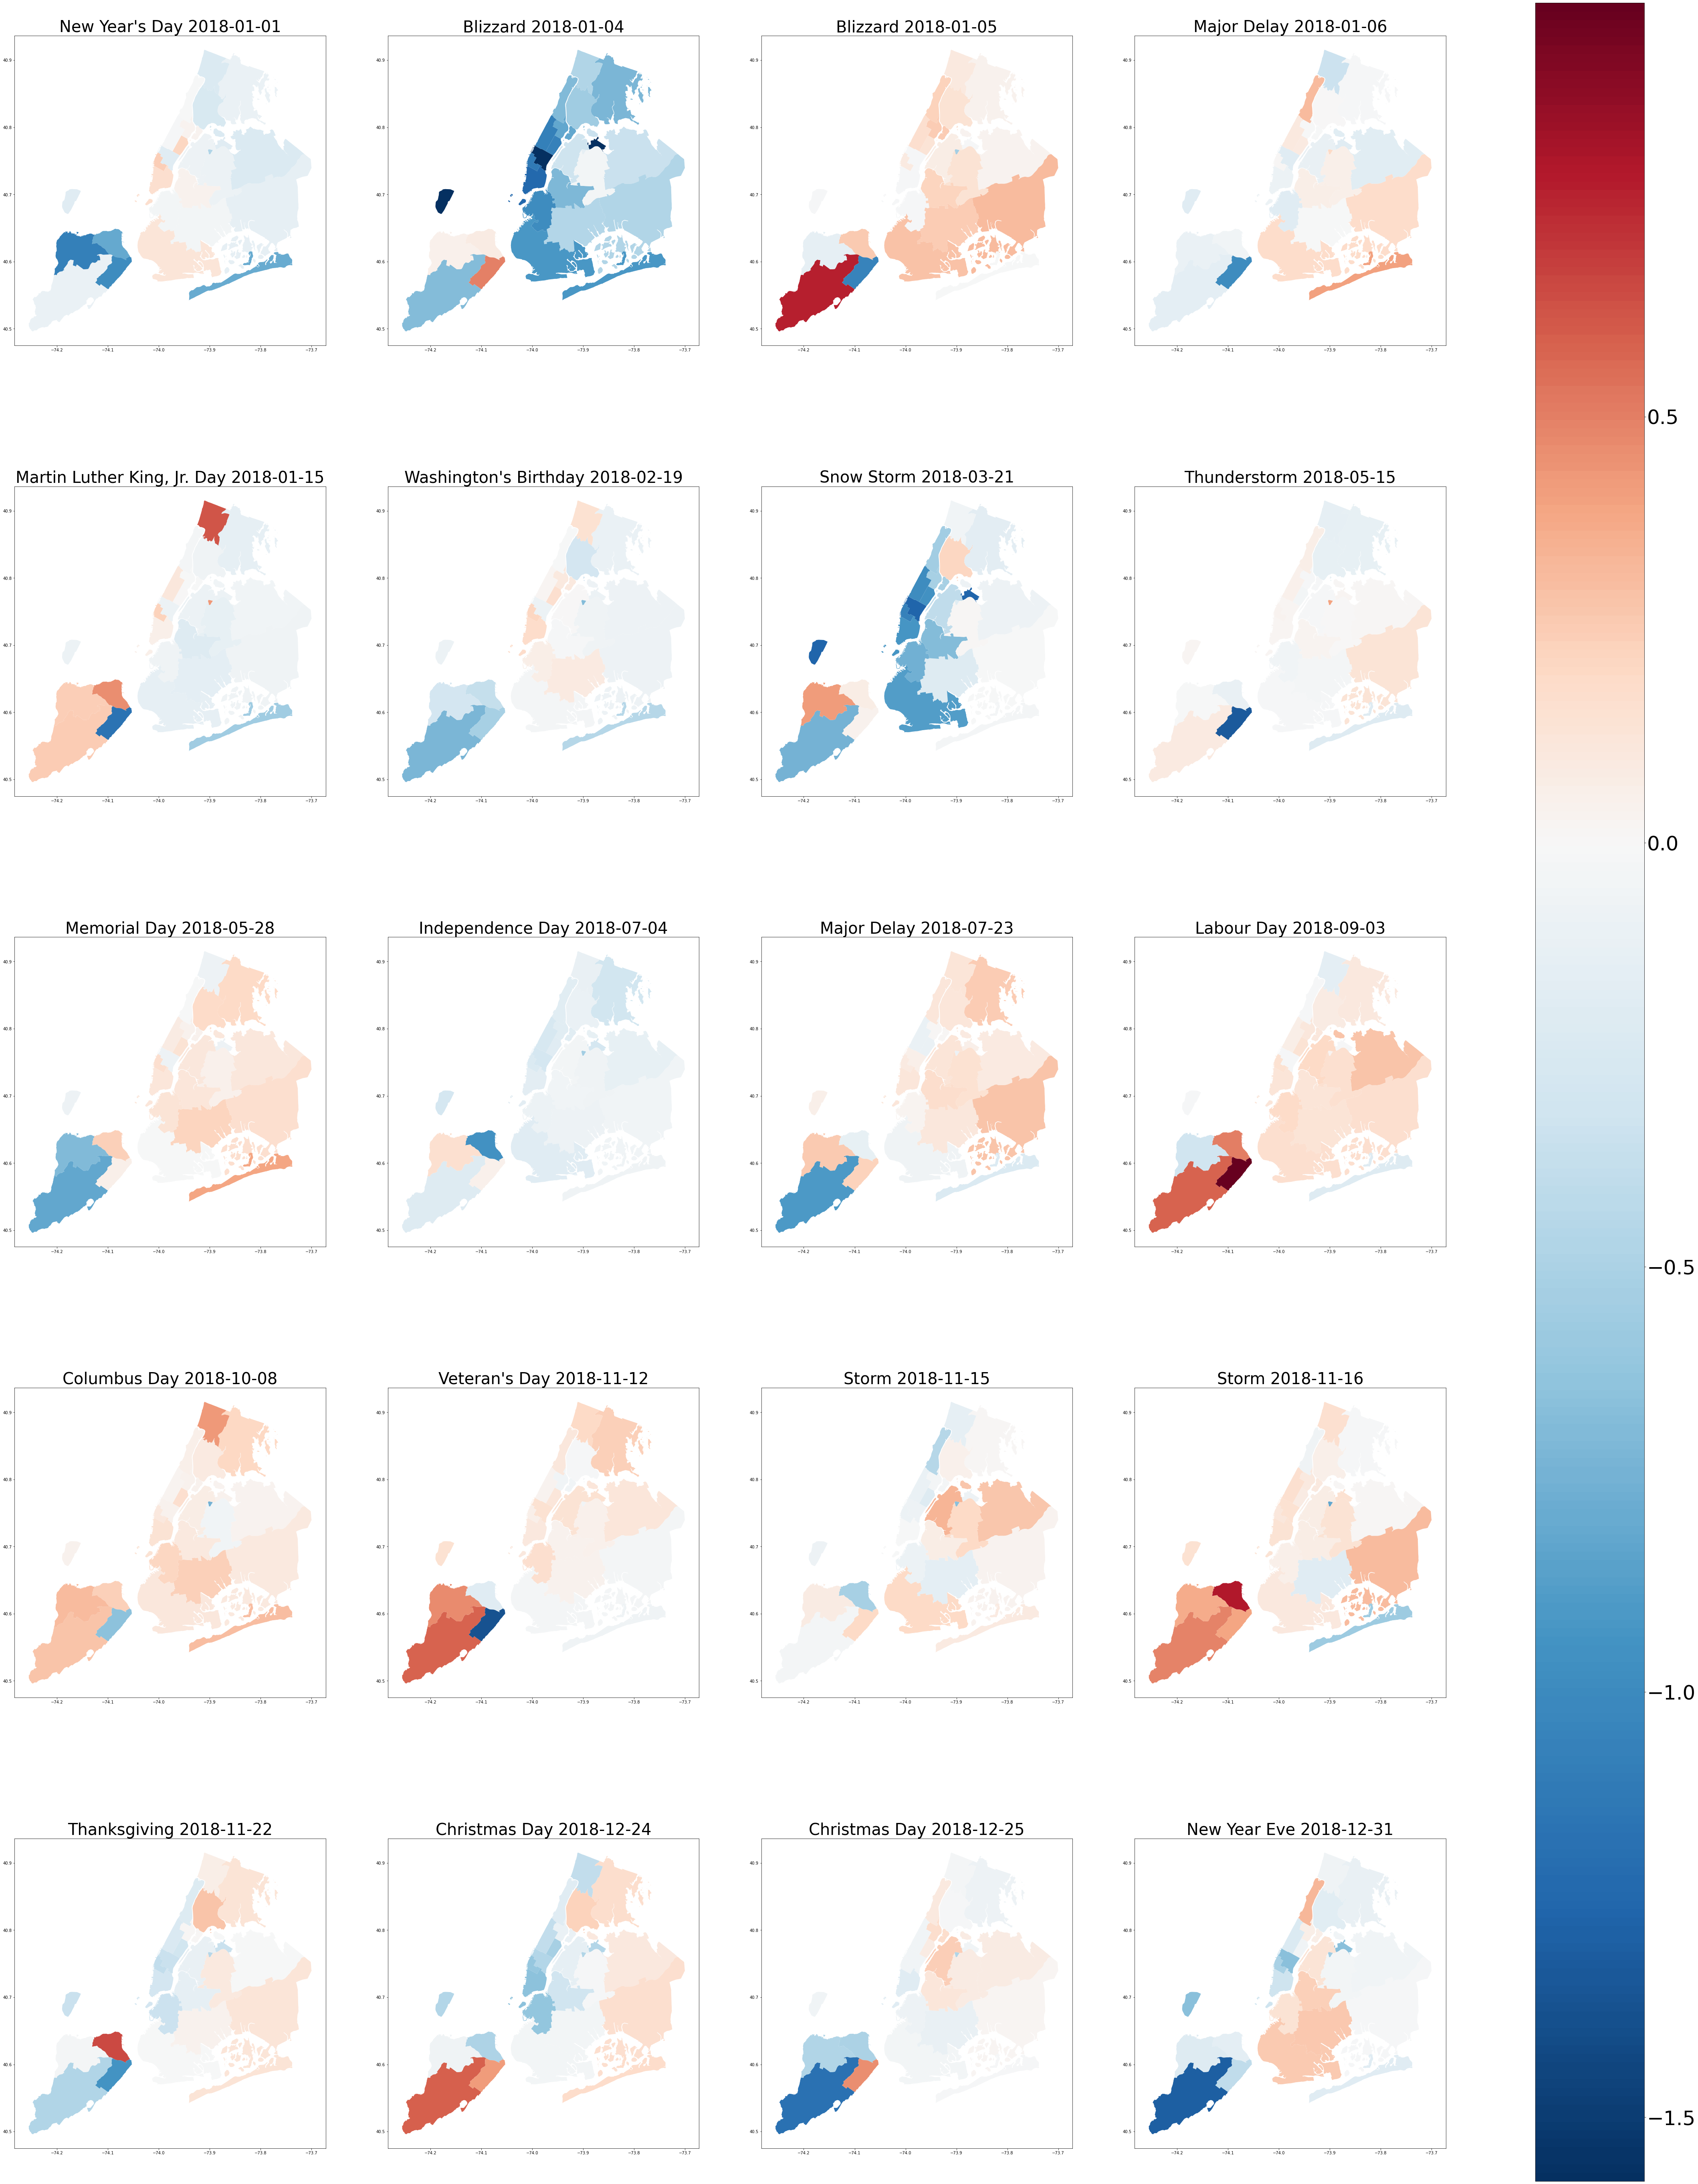

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()
fig,ax = plt.subplots(5, 4, figsize=(80, 100))
for ind, date in enumerate(events.Date):
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['Date']==date]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[int(ind/4),ind%4])

#     if ind%4 == 0:
#         fig.colorbar(cbar,ax = ax[int(ind/4),ind%4])

    ax[int(ind/4),ind%4].set_title(events.Name[ind]+' '+events.Date[ind], fontsize=40)
    
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=50)


In [17]:
fig.savefig('ResidulSpatialClusterLGA.jpg',dpi=150,bbox_inches='tight')

In [18]:
resid_normal_rate_map = zones.merge(resid_normal_rate,
            left_on='start_community',right_index=True)





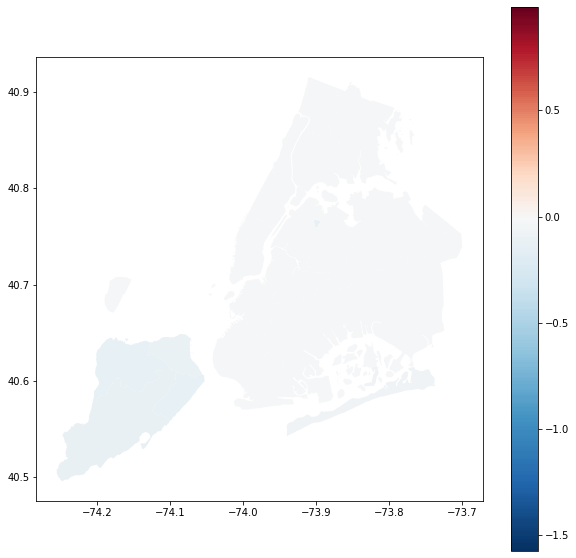

In [19]:
vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig,ax = plt.subplots(1, 1, figsize=(10, 10))
resid_normal_rate_map.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax)
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=10)

In [20]:
df = pd.pivot_table(resid_anomaly_rate,index='Date',values=['resid'],columns=['DOLocationID'])
X = df.values

In [21]:
def GMMBIC(matrix):

    bic = []
    for ncomp in range(2,6):
        gm=GaussianMixture(n_components=ncomp,n_init=100,max_iter=1000,random_state=0)
        labels = gm.fit_predict(matrix)
        score = gm.bic(matrix)
        bic += [score]
#         print(ncomp,score)
#     print('------------------------')
    GMMComp = np.array(bic).argmin() + 2
#         GMMBIC = np.array(bic).min()
    print('GMM in %s component has the lowest BIC value'%GMMComp)
    return GMMComp

In [22]:
GMMBIC(X)

GMM in 2 component has the lowest BIC value


2

In [23]:
gm=GaussianMixture(n_components=2,n_init=100,max_iter=1000,random_state=0)
labels = gm.fit_predict(X)

In [24]:
labels

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0])

In [25]:
events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
events['label'] = labels

In [26]:
events.loc[events['label']==1]

Type                         Name        Date  label
0   National Holiday               New Year's Day  2018-01-01      1
2    Extreme Weather                     Blizzard  2018-01-05      1
3      Airport Event                  Major Delay  2018-01-06      1
4   National Holiday  Martin Luther King, Jr. Day  2018-01-15      1
5   National Holiday        Washington's Birthday  2018-02-19      1
7    Extreme Weather                 Thunderstorm  2018-05-15      1
12  National Holiday                 Columbus Day  2018-10-08      1
13  National Holiday                Veteran's Day  2018-11-12      1
15   Extreme Weather                        Storm  2018-11-16      1
16  National Holiday                 Thanksgiving  2018-11-22      1

<Figure size 432x288 with 0 Axes>

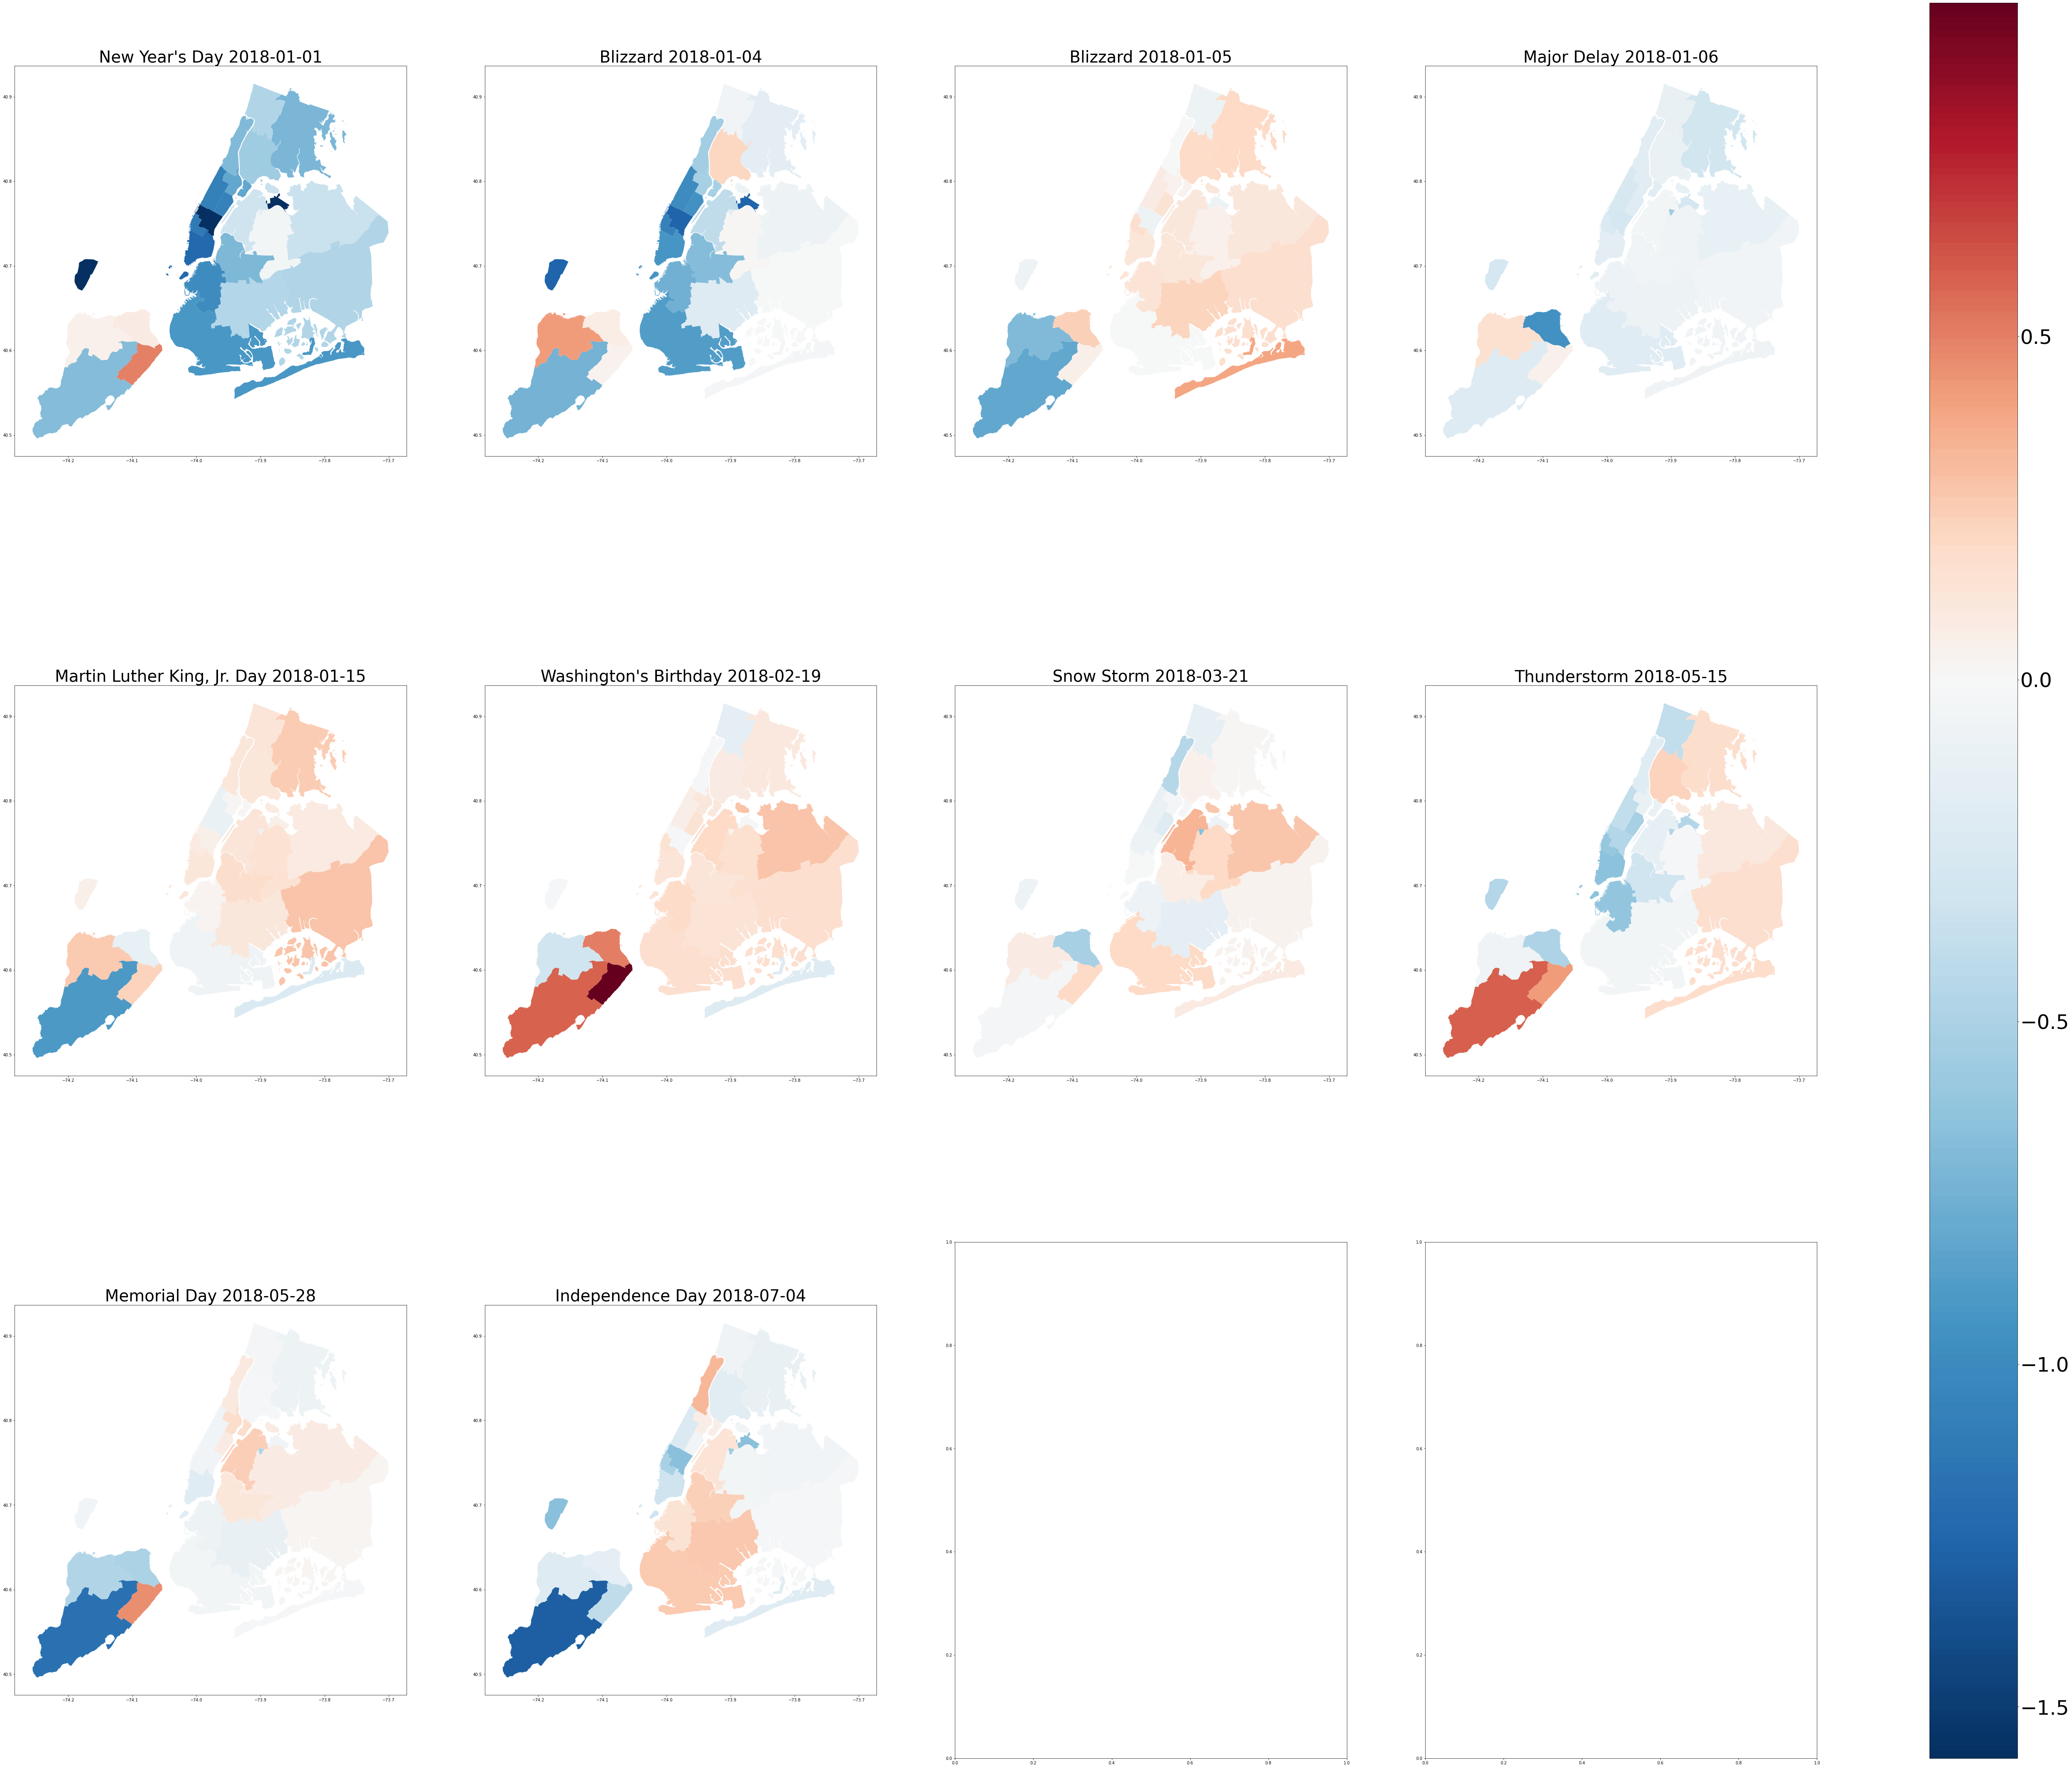

In [27]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()
fig,ax = plt.subplots(3, 4, figsize=(100, 80))
for ind, date in enumerate(events.loc[events['label']==0].Date):
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['Date']==date]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[int(ind/4),ind%4])

#     if ind%4 == 0:
#         fig.colorbar(cbar,ax = ax[int(ind/4),ind%4])

    ax[int(ind/4),ind%4].set_title(events.Name[ind]+' '+events.Date[ind], fontsize=40)
    
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=50)


<Figure size 432x288 with 0 Axes>

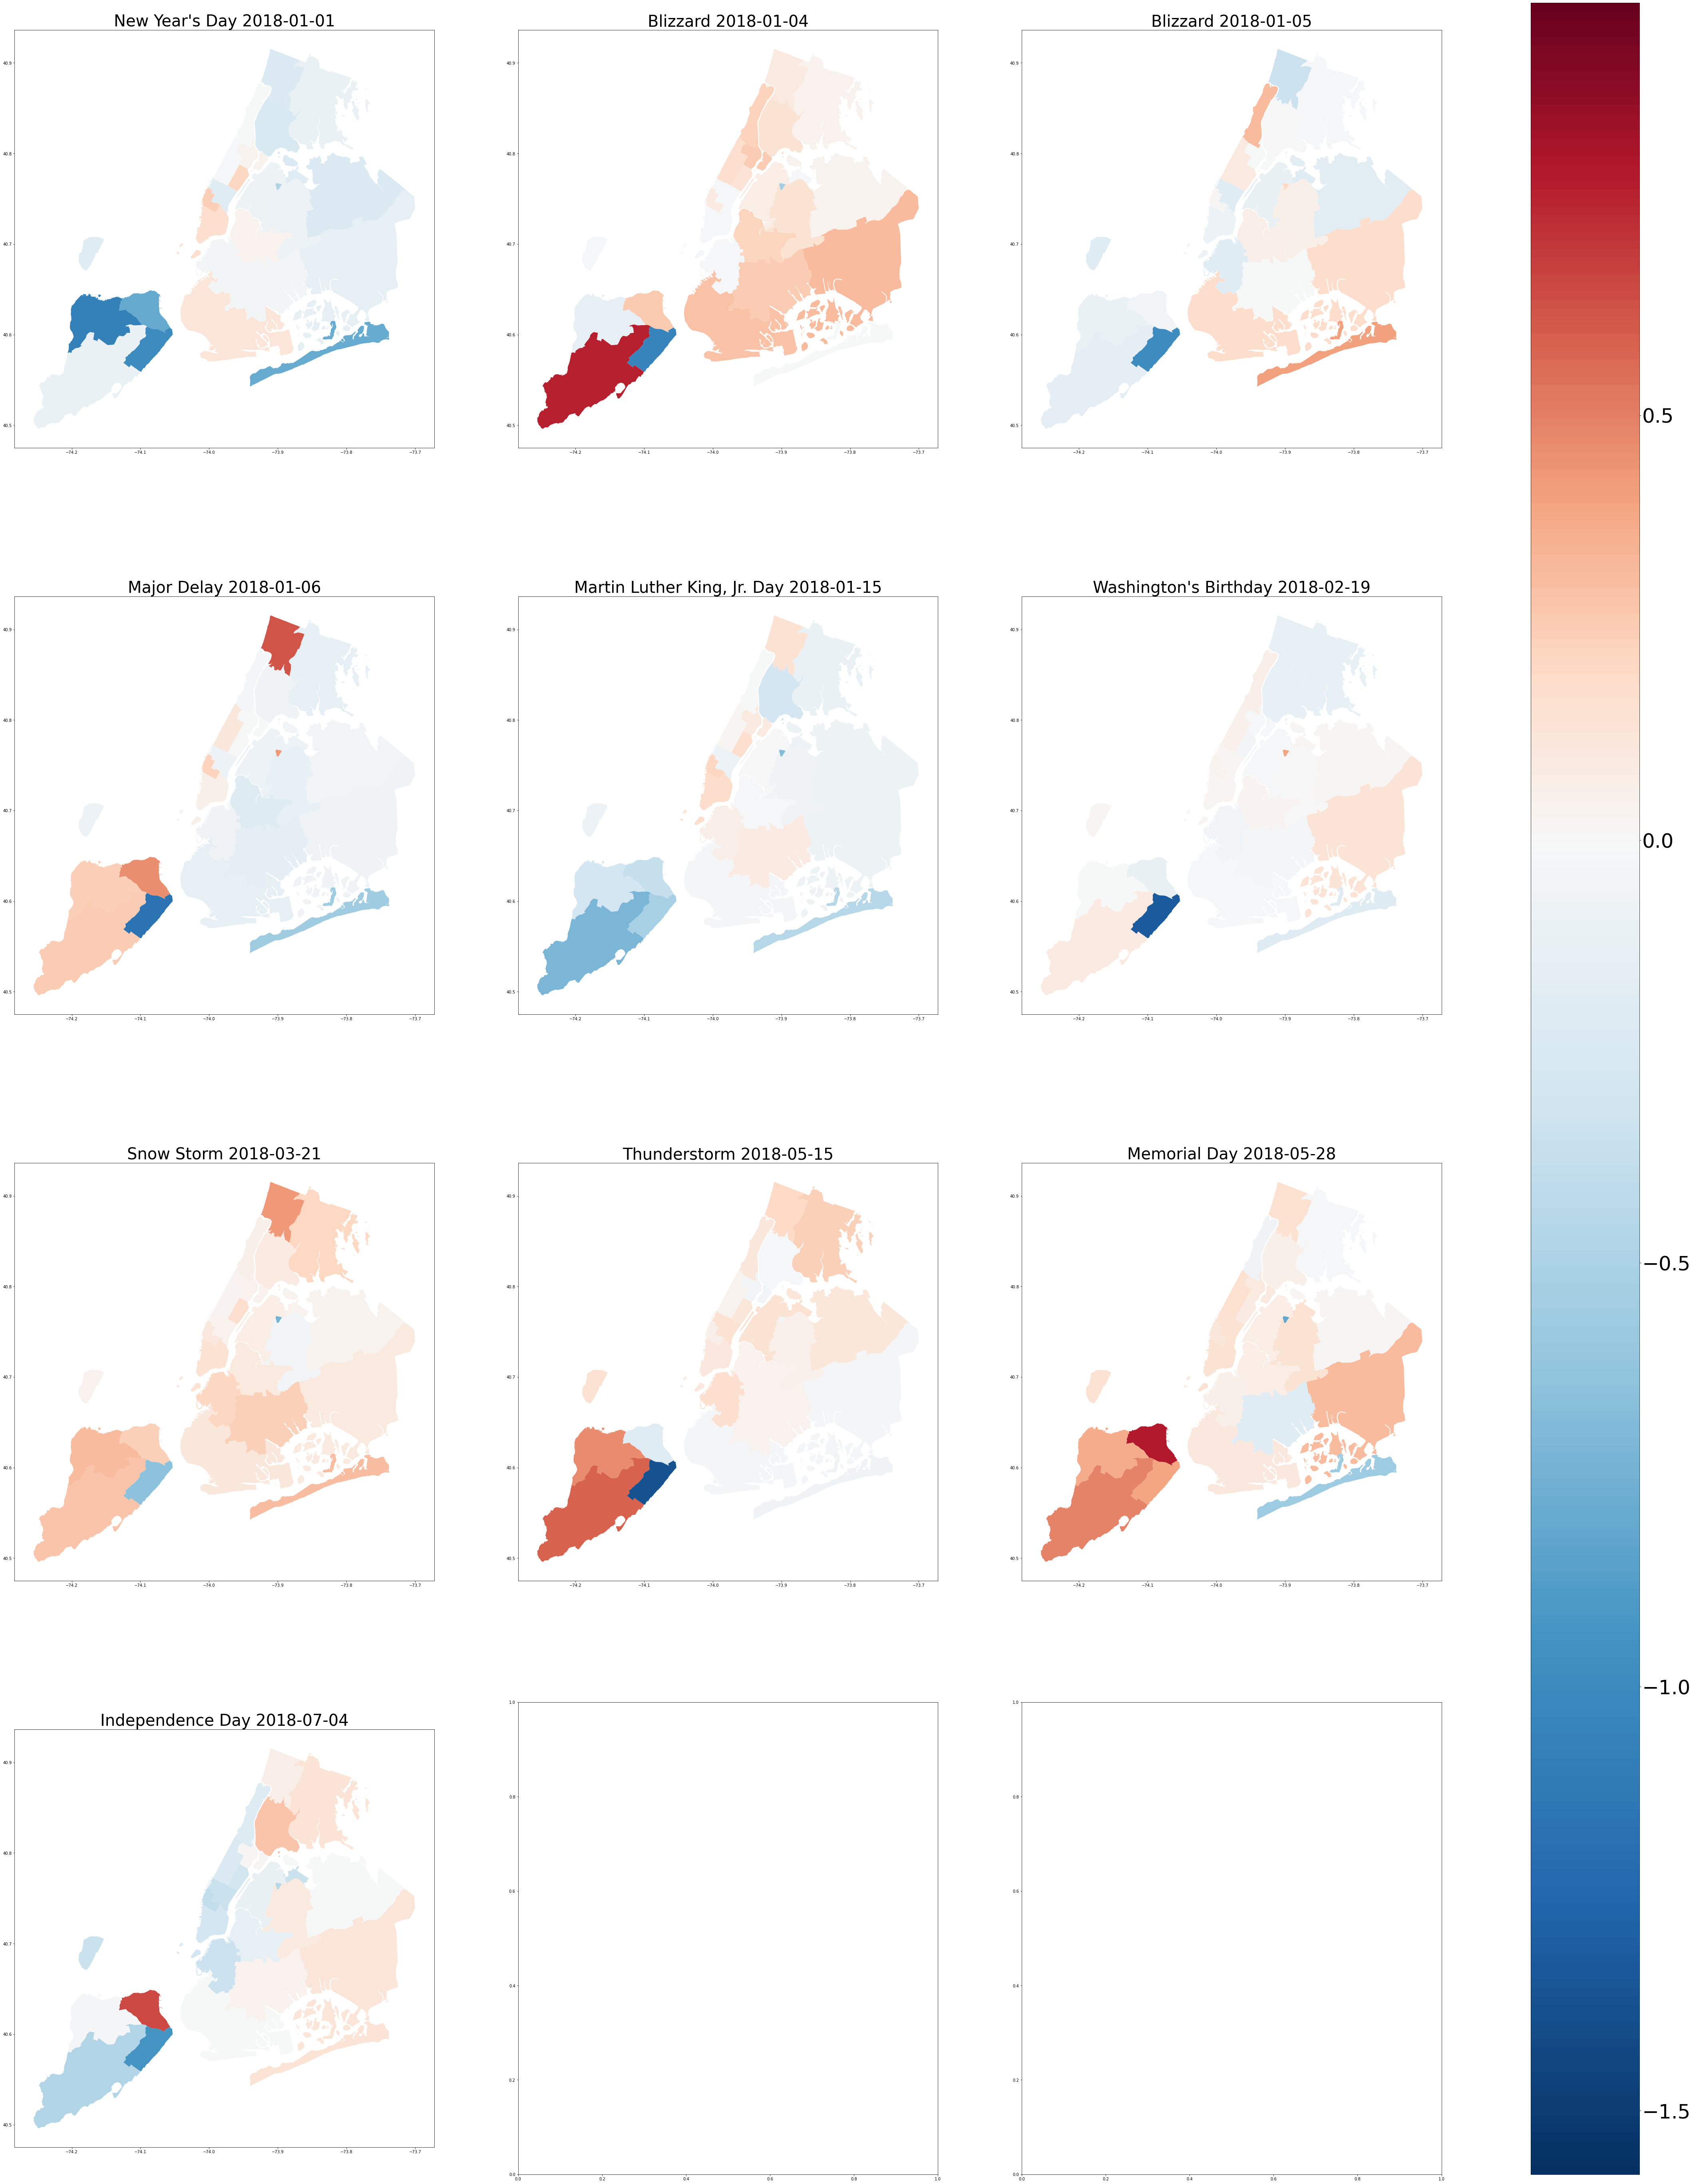

In [28]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()
fig,ax = plt.subplots(4, 3, figsize=(80, 100))
for ind, date in enumerate(events.loc[events['label']==1].Date):
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['Date']==date]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[int(ind/3),ind%3])

#     if ind%4 == 0:
#         fig.colorbar(cbar,ax = ax[int(ind/4),ind%4])

    ax[int(ind/3),ind%3].set_title(events.Name[ind]+' '+events.Date[ind], fontsize=40)
    
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=50)


In [29]:
df = df.droplevel(0, axis=1)
df['label'] = labels

In [30]:
zoneresid = df.groupby(['label']).sum().reset_index()
zoneresid = pd.melt(zoneresid,id_vars=['label'],var_name='DOLocationID',value_name='resid')

In [31]:
zoneresid.head()

label DOLocationID     resid
0      0      zone0.0 -4.417521
1      1      zone0.0 -0.547666
2      0      zone0.1 -3.263860
3      1      zone0.1  0.714924
4      0      zone0.2 -3.135228

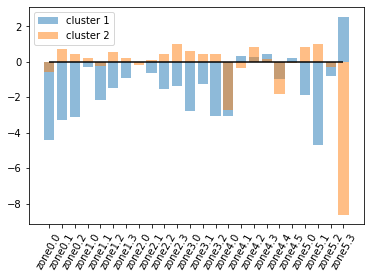

In [32]:

plotdf = zoneresid.loc[zoneresid['label']==0]
_ = plt.bar(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 1')
plotdf = zoneresid.loc[zoneresid['label']==1]
_ = plt.bar(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 2')
_ = plt.hlines(0, xmin=plotdf.DOLocationID.values[0],xmax=plotdf.DOLocationID.values[-1],color='k')
_ = plt.xticks(rotation=60)
plt.legend()

In [33]:
resid_anomaly_rate_map = zones.merge(zoneresid.groupby(['label','DOLocationID']).sum().reset_index(),
            left_on='start_community',right_on='DOLocationID')
resid_anomaly_rate_map.head()

start_community                                           geometry  label  \
0         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...      0   
1         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...      1   
2         zone0.1  POLYGON ((-73.98997 40.73490, -73.98990 40.734...      0   
3         zone0.1  POLYGON ((-73.98997 40.73490, -73.98990 40.734...      1   
4         zone0.2  MULTIPOLYGON (((-74.01395 40.70099, -74.01409 ...      0   

  DOLocationID     resid  
0      zone0.0 -4.417521  
1      zone0.0 -0.547666  
2      zone0.1 -3.263860  
3      zone0.1  0.714924  
4      zone0.2 -3.135228

<Figure size 432x288 with 0 Axes>

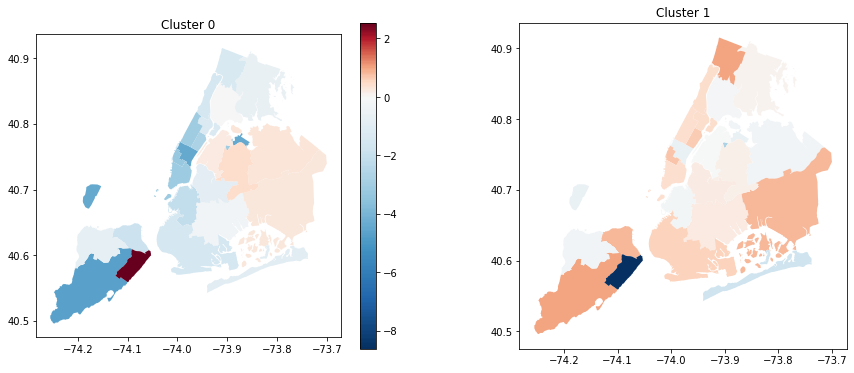

In [34]:

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()

fig,ax = plt.subplots(1, 2,figsize=(15,6))
plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==0]
plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[0])
ax[0].set_title('Cluster 0')
plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==1]
plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[1])
ax[1].set_title('Cluster 1')
    
cb = fig.colorbar(cbar, ax=ax[0])
cb.ax.tick_params(labelsize=10)

In [38]:
# residual in all days

path = "/home/mingyi/Dropbox/DOE_Anomaly_Detection/GMMDataset/selected/RFCV/%sPCA6RFCVResidDailyAggregated.csv"%hub
resid = pd.read_csv(path)
matrix = resid.drop(columns=['Date']).values

In [42]:
comp = GMMBIC(matrix)

GMM in 5 component has the lowest BIC value


In [51]:
path = "/home/mingyi/Dropbox/DOE_Anomaly_Detection/GMMDataset/selected/GMMIteration/RFCV/%sPCA6RFCVResidAnomalyDetectionIterationOutput.csv"%hub
iterationDF = pd.read_csv(path)

In [53]:
iterationDF = iterationDF[[col for col in iterationDF.columns if '%s-'%comp in col]+['Date']]

In [54]:
iterationDF


5-0.0  5-0.01  5-0.02  5-0.03  5-0.04  5-0.05  5-0.06  5-0.07  5-0.08  \
0    False   False   False   False   False   False   False   False   False   
1    False   False   False   False   False   False   False   False   False   
2    False   False   False   False   False   False   False   False   False   
3    False   False   False   False   False   False   False   False   False   
4    False   False   False   False   False   False   False   False   False   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
360  False   False   False   False    True    True    True    True    True   
361  False   False   False   False    True    True    True    True    True   
362  False   False   False   False    True    True    True    True    True   
363  False   False   False    True    True    True    True    True    True   
364  False   False    True    True    True    True    True    True    True   

     5-0.09  ...  5-0.9  5-0.91  5-0.92  5-0.93  5-0.94  5-0.95  5-0.96  \
0     False  ...   True    True    True    True    True    True    True   
1      True  ...   True    True    True    True    True    True    True   
2     False  ...   True    True    True    True    True    True    True   
3     False  ...   True    True    True    True    True    True    True   
4     False  ...   True    True    True    True    True    True    True   
..      ...  ...    ...     ...     ...     ...     ...     ...     ...   
360    True  ...   True    True    True    True    True    True    True   
361    True  ...   True    True    True    True    True    True    True   
362    True  ...   True    True    True    True    True    True    True   
363    True  ...   True    True    True    True    True    True    True   
364    True  ...   True    True    True    True    True    True    True   

     5-0.97  5-0.98        Date  
0      True    True  2018-01-01  
1      True    True  2018-01-02  
2      True    True  2018-01-03  
3      True    True  2018-01-04  
4      True    True  2018-01-05  
..      ...     ...         ...  
360    True    True  2018-12-27  
361    True    True  2018-12-28  
362    True    True  2018-12-29  
363    True    True  2018-12-30  
364    True    True  2018-12-31  

[365 rows x 100 columns]

In [66]:
events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
events['Anomaly'] = True
events = events[['Anomaly','Date']].merge(iterationDF[['Date']],on='Date',how='right').fillna(False).sort_values(by='Date')

In [67]:
events

Anomaly        Date
0       True  2018-01-01
20     False  2018-01-02
21     False  2018-01-03
1       True  2018-01-04
2       True  2018-01-05
..       ...         ...
361    False  2018-12-27
362    False  2018-12-28
363    False  2018-12-29
364    False  2018-12-30
19      True  2018-12-31

[365 rows x 2 columns]

In [68]:
y_true = events['Anomaly'].values
f1 = {}
for col in iterationDF.columns:
    if col != 'Date':
        y_pred = iterationDF[col].values
        score = f1_score(y_true,y_pred)
        f1[col] = score

In [69]:
thre = [key for key in f1.keys() if f1[key] == max(f1.values())]
thre

['5-0.16']

In [71]:
f1[thre[0]]

0.282051282051282

In [72]:
iterationDF[thre].sum()

5-0.16    58
dtype: int64

In [73]:
# TP / (TP+FP)
precision_score(y_true,iterationDF[thre])

0.1896551724137931

In [74]:
# TP / (TP+FN)
recall_score(y_true,iterationDF[thre])

0.55

In [75]:
events = iterationDF.loc[iterationDF[thre[0]]==True][['Date']]
events

Date
0    2018-01-01
1    2018-01-02
4    2018-01-05
12   2018-01-13
13   2018-01-14
15   2018-01-16
27   2018-01-28
35   2018-02-05
49   2018-02-19
56   2018-02-26
76   2018-03-18
90   2018-04-01
92   2018-04-03
99   2018-04-10
105  2018-04-16
130  2018-05-11
141  2018-05-22
147  2018-05-28
148  2018-05-29
175  2018-06-25
203  2018-07-23
224  2018-08-13
231  2018-08-20
233  2018-08-22
234  2018-08-23
235  2018-08-24
238  2018-08-27
239  2018-08-28
240  2018-08-29
242  2018-08-31
244  2018-09-02
245  2018-09-03
246  2018-09-04
253  2018-09-11
269  2018-09-27
274  2018-10-02
280  2018-10-08
281  2018-10-09
316  2018-11-13
318  2018-11-15
319  2018-11-16
330  2018-11-27
336  2018-12-03
337  2018-12-04
339  2018-12-06
340  2018-12-07
343  2018-12-10
344  2018-12-11
346  2018-12-13
354  2018-12-21
356  2018-12-23
357  2018-12-24
359  2018-12-26
360  2018-12-27
361  2018-12-28
362  2018-12-29
363  2018-12-30
364  2018-12-31

In [76]:
def ResidinAnomaly(hub,method,events):
    label = pd.read_csv('../processedData/'+hub+'VehicleByHour.csv')
    label = label.merge(zoneDict, on='DOLocationID')
    label = getTimeSeries(label)
    label = label.reset_index()
    label.columns = [str(col) for col in label.columns]

    prediction = pd.read_csv('../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction['DOLocationID'] = prediction['DOLocationID'].astype(int)
    prediction = prediction.merge(zoneDict, on='DOLocationID')
    prediction = getTimeSeries(prediction)
    prediction = prediction.reset_index()
    prediction.columns = [str(col) for col in prediction.columns]

    label = label.merge(prediction[['Date','Hour']],on=['Date','Hour'],how='inner')
    label_value = label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])].values
    selectedColumn = sorted([str(x) for x in prediction.columns if x not in ['Date', 'Hour']])

    prediction_value = prediction[[str(col) for col in selectedColumn]].values

    label_anomaly = events.merge(label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])+['Date']],
                                 how='inner',on='Date')

    prediction_anomaly = events.merge(prediction[[str(col) for col in selectedColumn]+['Date']],how='inner',on='Date')
    label_anomaly_value = label_anomaly[[x for x in label_anomaly.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    prediction_anomaly_value = prediction_anomaly[[x for x in prediction_anomaly.columns 
                                                         if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    mask = label['Date'].isin(events['Date'])
    label_normal = label[~mask]
    label_normal_value = label_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()
    mask = prediction['Date'].isin(events['Date'])
    prediction_normal = prediction[~mask]
    prediction_normal_value = prediction_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()



    resid_anomaly_rate = np.log((label_anomaly_value+1)/(prediction_anomaly_value+1))
    resid_anomaly_rate = resid_anomaly_rate.merge(events, on='Date')
    resid_anomaly_rate = pd.melt(resid_anomaly_rate, id_vars=['Date'],var_name='DOLocationID',value_name='resid')
    
    resid_normal_rate = np.log((label_normal_value+1)/(prediction_normal_value+1))
    resid_normal_rate = pd.DataFrame(resid_normal_rate.mean(axis=0),columns=['resid'])

    return (resid_anomaly_rate, resid_normal_rate)

In [107]:
resid_anomaly_rate, resid_normal_rate = ResidinAnomaly(hub,method,events)

In [108]:
df = pd.pivot_table(resid_anomaly_rate,index='Date',values=['resid'],columns=['DOLocationID'])
X = df.values

In [109]:
GMMBIC(X)

GMM in 5 component has the lowest BIC value


5

In [110]:
gm=GaussianMixture(n_components=5,n_init=100,max_iter=1000,random_state=0)
labels = gm.fit_predict(X)

In [111]:
events['label'] = labels

In [113]:
artificial = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())

In [114]:
eventscompare = events.merge(artificial,on='Date',how='left')
eventscompare.loc[eventscompare['label']==1]

Date  label             Type   Name
1   2018-01-02      1              NaN    NaN
7   2018-02-05      1              NaN    NaN
11  2018-04-01      1              NaN    NaN
12  2018-04-03      1              NaN    NaN
13  2018-04-10      1              NaN    NaN
19  2018-06-25      1              NaN    NaN
29  2018-08-31      1              NaN    NaN
32  2018-09-04      1              NaN    NaN
34  2018-09-27      1              NaN    NaN
39  2018-11-15      1  Extreme Weather  Storm
40  2018-11-16      1  Extreme Weather  Storm
42  2018-12-03      1              NaN    NaN
54  2018-12-28      1              NaN    NaN

In [115]:
resid_anomaly_rate['DOLocationID'] = 'zone' + resid_anomaly_rate['DOLocationID'].astype(str)

<Figure size 432x288 with 0 Axes>

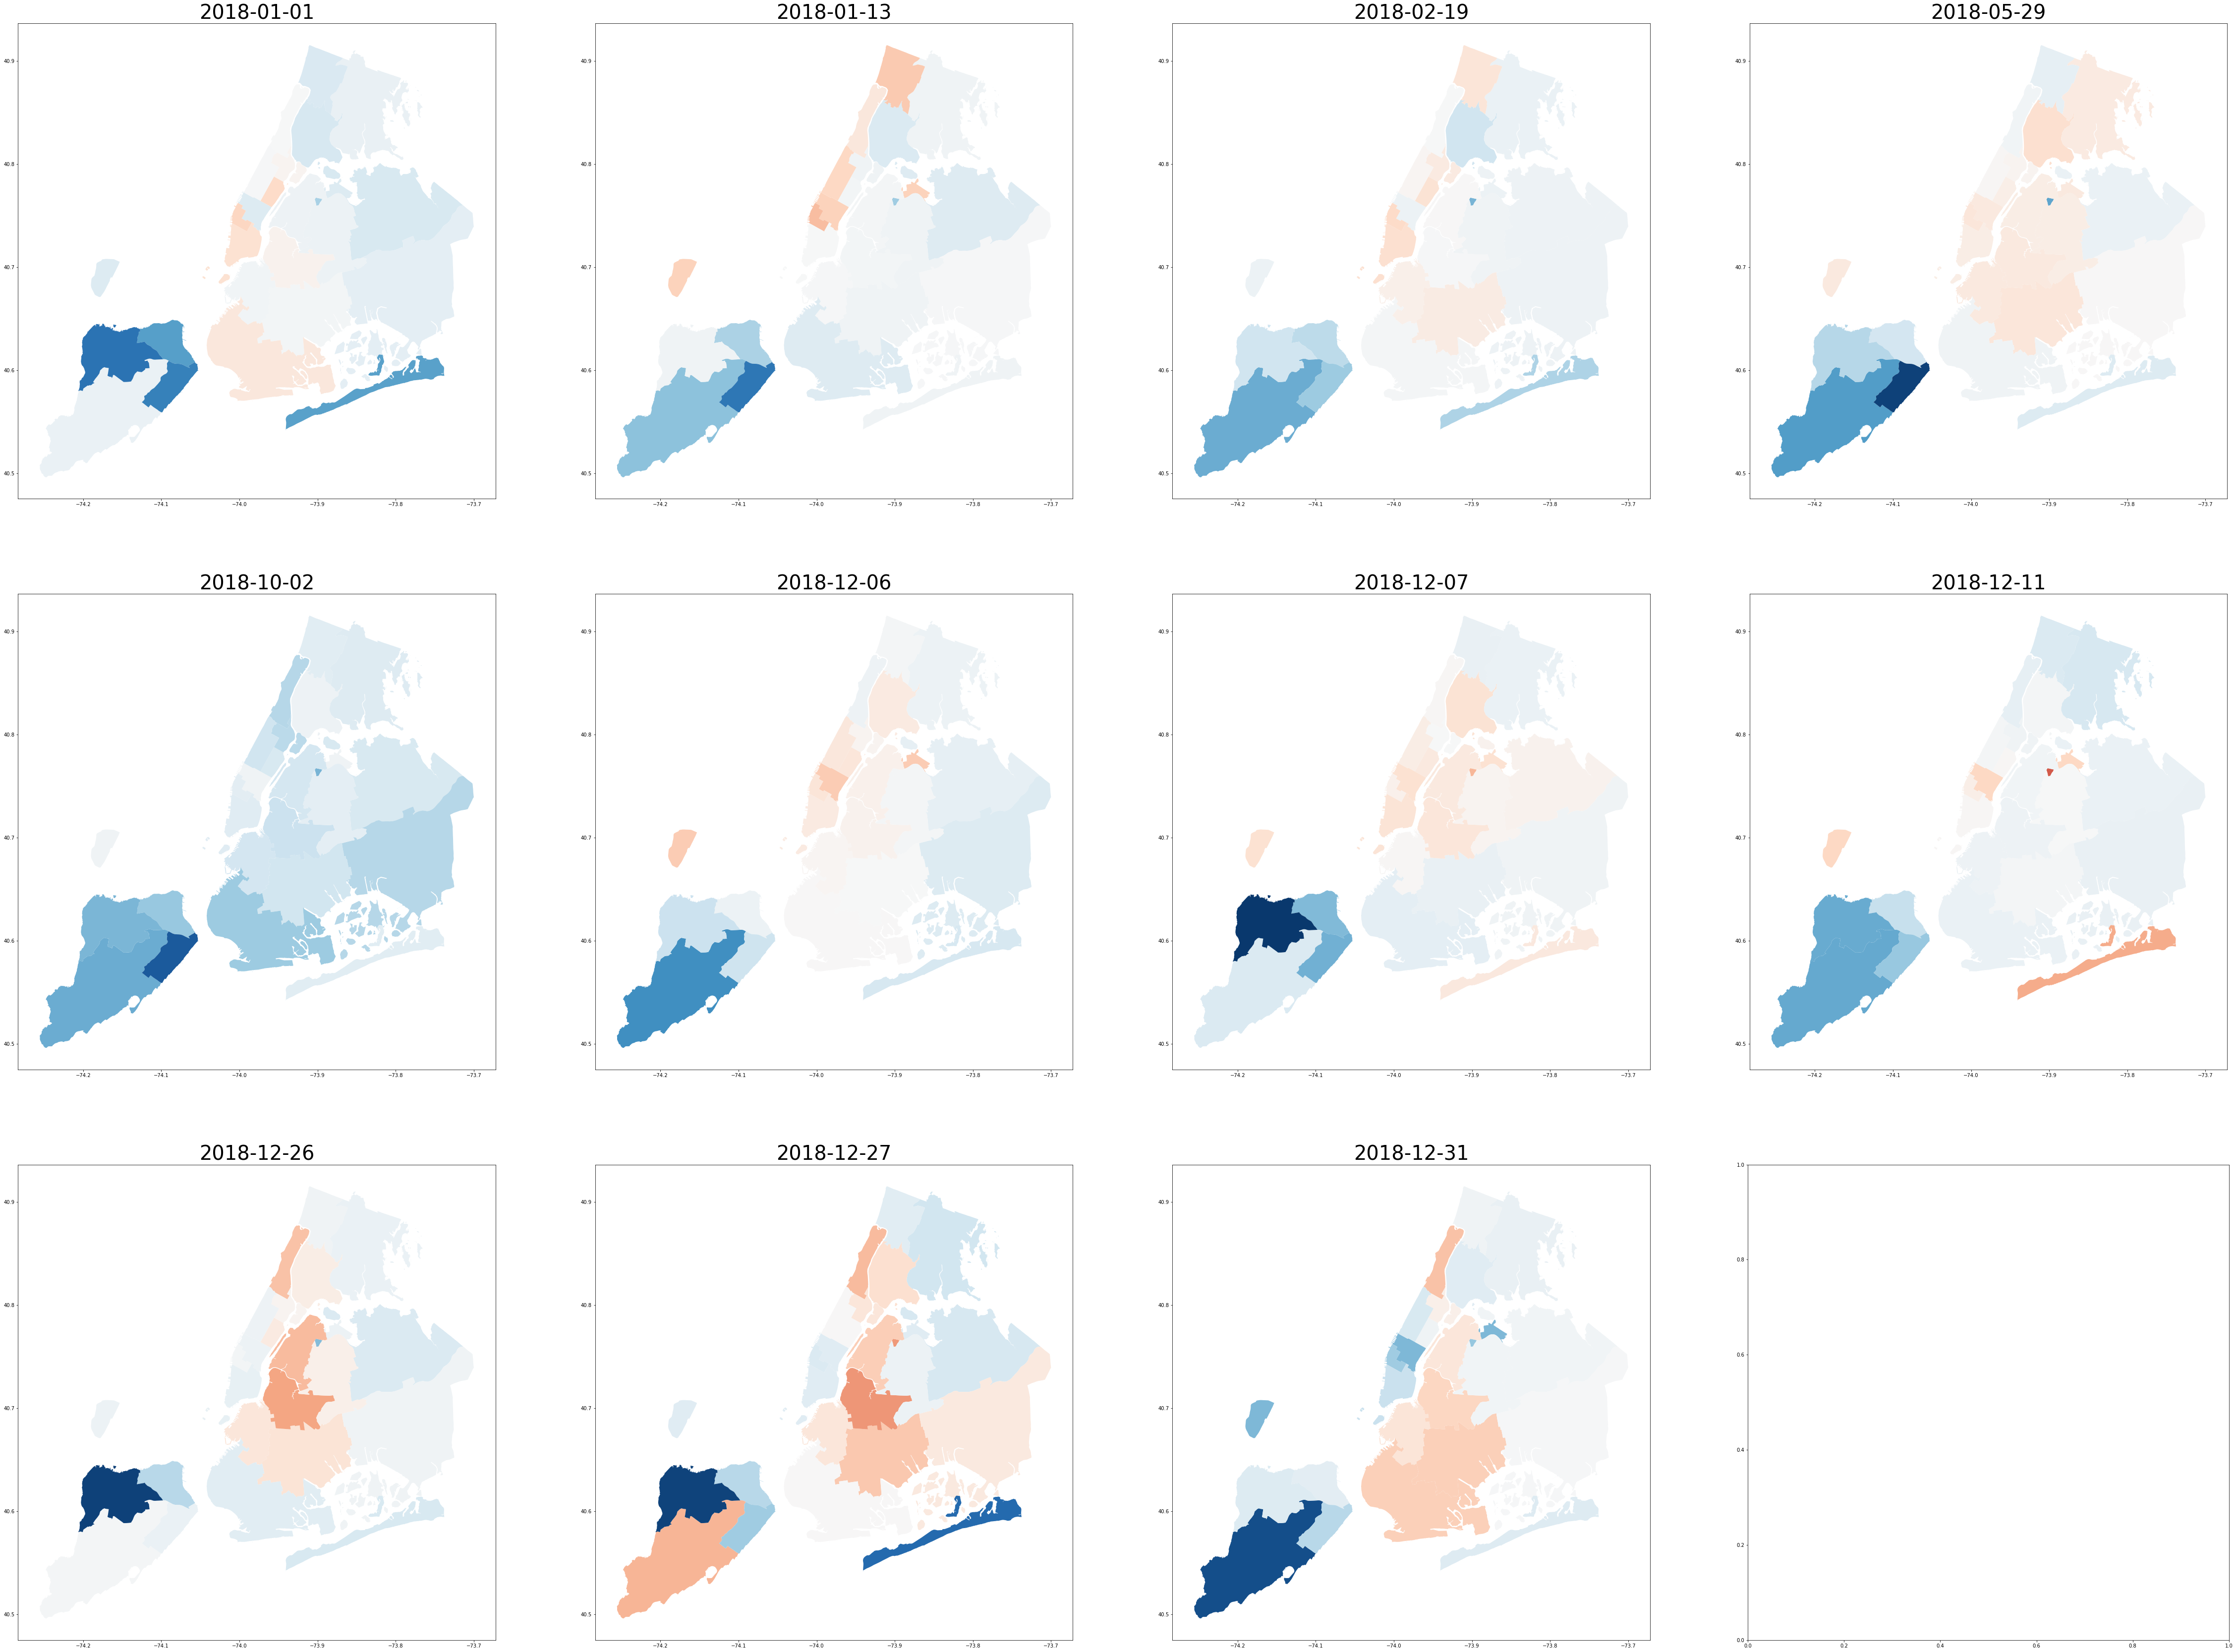

In [116]:

resid_anomaly_rate_map = zones.merge(resid_anomaly_rate,
            left_on='start_community',right_on='DOLocationID')

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()

fig,ax = plt.subplots(3, 4, figsize=(80, 60))
for ind, date in enumerate(events.loc[events['label']==0].Date):
#     print(int(ind/3))
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['Date']==date]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[int(ind/4),ind%4])

    ax[int(ind/4),ind%4].set_title(events.loc[events['label']==0].Date.values[ind], fontsize=40)
    
# cb = fig.colorbar(cbar, ax=ax)
# cb.ax.tick_params(labelsize=50)


In [118]:
df = df.droplevel(0, axis=1)
df['label'] = labels

In [128]:
len(labels)

58

In [122]:
df.groupby(['label']).sum()

DOLocationID       0.0       0.1       0.2       1.0       1.1       1.2  \
label                                                                      
0            -0.228708  0.276207 -0.109707  0.409792  0.197747 -0.842311   
1             0.094514  0.194261  0.684566  0.250741  0.177721  0.724898   
2            -0.582372 -0.777810 -1.409721 -0.308349 -1.214327 -0.658230   
3            -0.432517 -0.208389 -0.204688  1.521066  0.144324  1.412090   
4            -0.182933  0.222560  0.453538  1.903499  0.577696  1.160990   

DOLocationID       1.3       2.0       2.1       2.2  ...       4.2       4.3  \
label                                                 ...                       
0             1.065353 -0.310936 -1.271243  0.457761  ... -1.011772 -0.354093   
1             0.984278  0.538054  0.308898  0.223390  ... -0.209693  0.523944   
2            -0.915790 -0.777888 -0.157082 -0.401251  ... -0.876760 -0.469727   
3             0.511701  0.795439  1.304532  0.659938  ...  1.238752  0.581771   
4             1.280840  1.174467  1.827214  0.796535  ...  1.856251  0.934212   

DOLocationID       4.4       4.5       5.0       5.1       5.2       5.3  \
label                                                                      
0            -2.955855  0.597884 -4.495308 -5.784268 -7.902296 -7.748835   
1            -1.431560  1.002686 -0.352467  1.189193  0.138320  0.610281   
2             0.632472 -0.695814 -5.379880 -0.472053  0.278369 -0.087754   
3             1.306015  0.238628  2.607490  2.951055  2.533778 -7.304637   
4             2.540738  1.365472  3.116977 -1.910364  0.951783  3.389953   

DOLocationID  label_x  label_y  
label                           
0                 0.0     44.0  
1                 0.0     13.0  
2                 0.0      0.0  
3                 0.0     20.0  
4                 0.0     39.0  

[5 rows x 26 columns]

In [133]:
df.columns

Index(['0.0', '0.1', '0.2', '1.0', '1.1', '1.2', '1.3', '2.0', '2.1', '2.2',
       '2.3', '3.0', '3.1', '3.2', '4.0', '4.1', '4.2', '4.3', '4.4', '4.5',
       '5.0', '5.1', '5.2', '5.3', 'label_x', 'label_y', 'label'],
      dtype='object', name='DOLocationID')

In [135]:
selectedCol = ['0.0', '0.1', '0.2', '1.0', '1.1', '1.2', '1.3', '2.0', '2.1', '2.2',
       '2.3', '3.0', '3.1', '3.2', '4.0', '4.1', '4.2', '4.3', '4.4', '4.5',
       '5.0', '5.1', '5.2', '5.3']


No handles with labels found to put in legend.


Text(0.5, 0, 'zone')

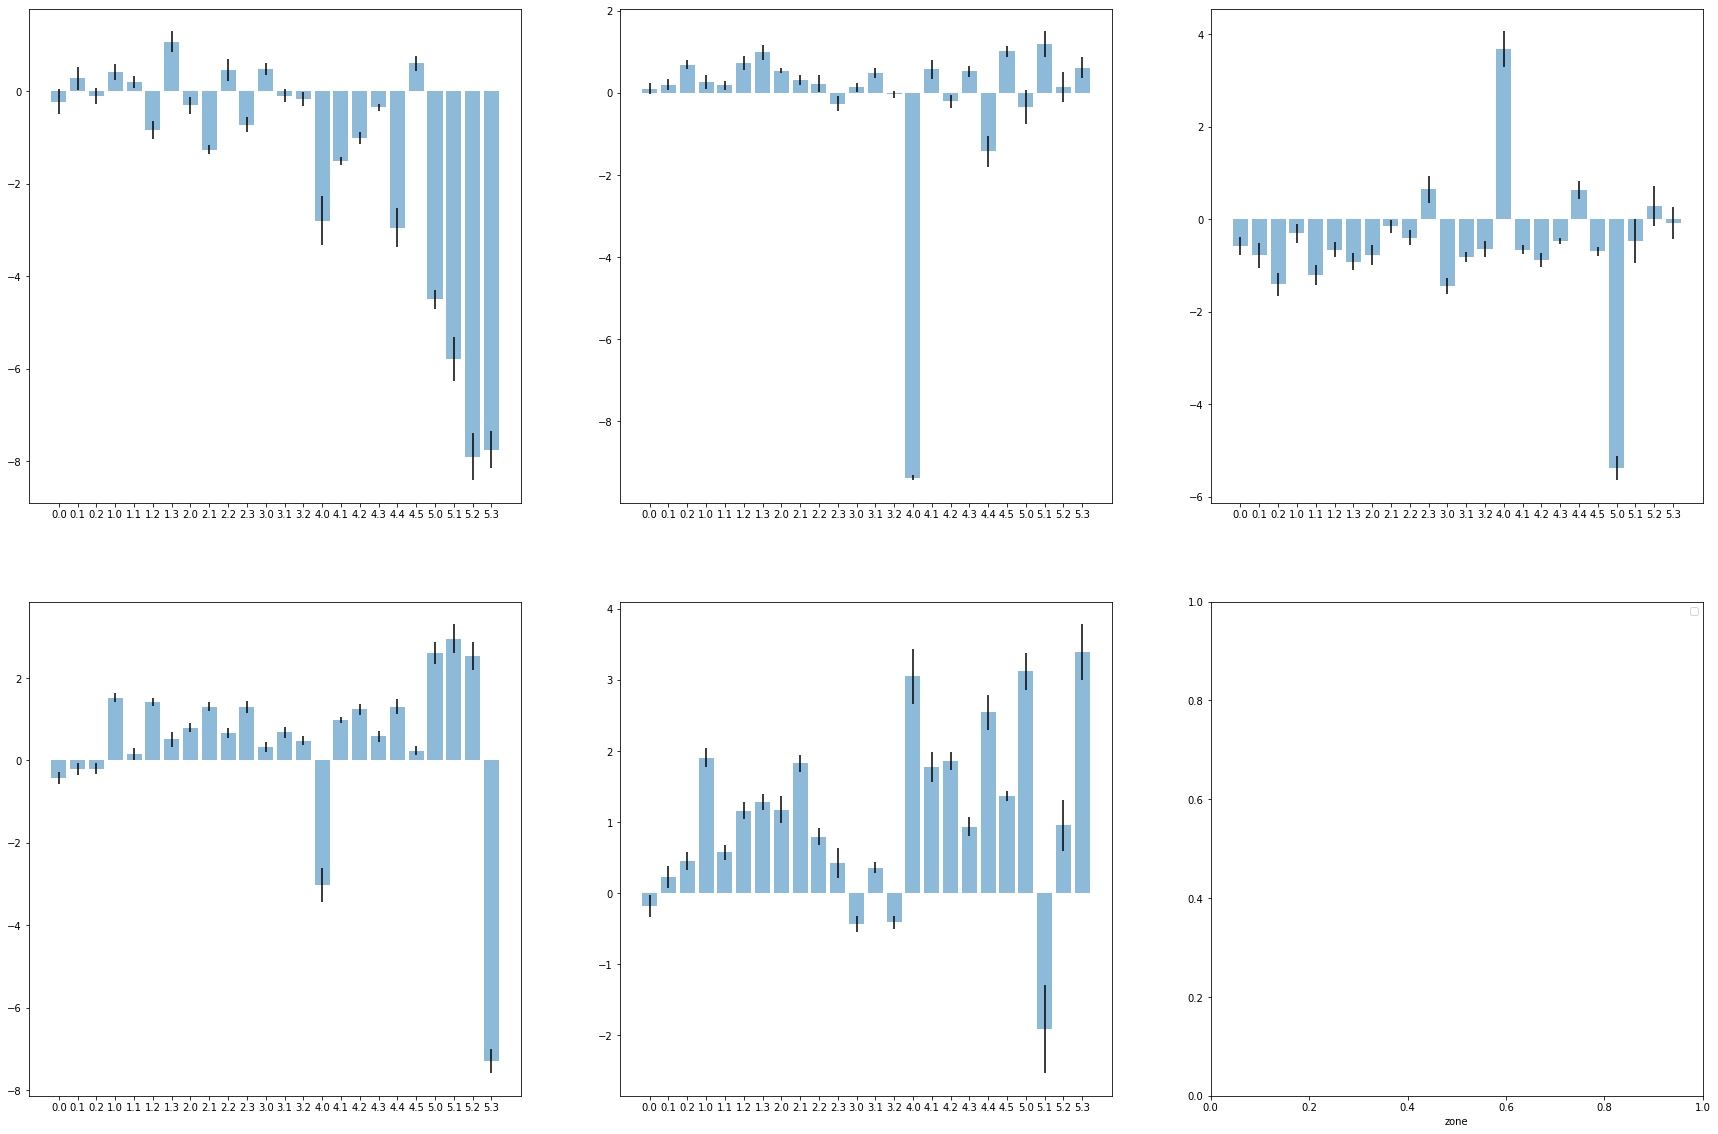

In [138]:

zoneresid = df.groupby(['label']).sum().reset_index()
del zoneresid['label_x']
del zoneresid['label_y']
zoneresid = pd.melt(zoneresid,id_vars=['label'],var_name='DOLocationID',value_name='resid')

fig,ax = plt.subplots(2,3,figsize=(30,20))
plotdf = zoneresid.loc[zoneresid['label']==0]
_ = ax[0,0].bar(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 1',
                yerr=df.loc[df['label']==0][selectedCol].std())

plotdf = zoneresid.loc[zoneresid['label']==1]
_ = ax[0,1].bar(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 2',
               yerr=df.loc[df['label']==1][selectedCol].std())

plotdf = zoneresid.loc[zoneresid['label']==2]
_ = ax[0,2].bar(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 3',
                yerr=df.loc[df['label']==2][selectedCol].std())

plotdf = zoneresid.loc[zoneresid['label']==3]
_ = ax[1,0].bar(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 4',
                yerr=df.loc[df['label']==3][selectedCol].std())

plotdf = zoneresid.loc[zoneresid['label']==4]
_ = ax[1,1].bar(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 5',
                yerr=df.loc[df['label']==4][selectedCol].std())

# _ = plt.hlines(0, xmin=plotdf.DOLocationID.values[0],xmax=plotdf.DOLocationID.values[-1],color='k')
# _ = plt.xticks(rotation=60)
plt.legend()
plt.xlabel('zone')

In [139]:
zoneresid.DOLocationID = 'zone'+zoneresid.DOLocationID
resid_anomaly_rate_map = zones.merge(zoneresid.groupby(['label','DOLocationID']).sum().reset_index(),
            left_on='start_community',right_on='DOLocationID')

<Figure size 432x288 with 0 Axes>

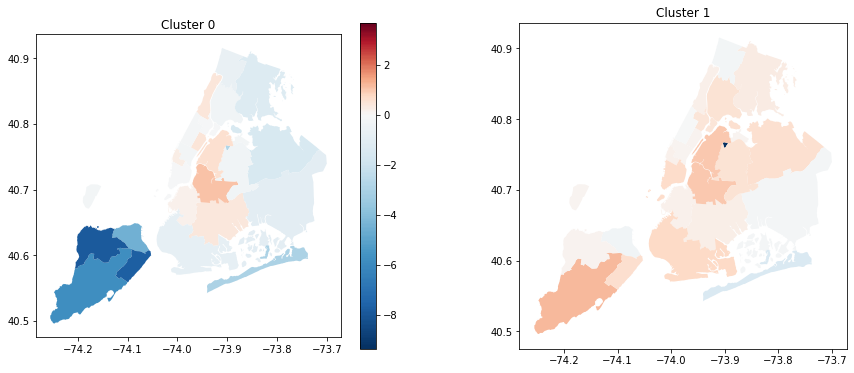

In [140]:
vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()

fig,ax = plt.subplots(1, 2,figsize=(15,6))
plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==0]
plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[0])
ax[0].set_title('Cluster 0')

plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==1]
plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[1])
ax[1].set_title('Cluster 1')
    
cb = fig.colorbar(cbar, ax=ax[0])
cb.ax.tick_params(labelsize=10)

In [351]:
artificial

Type                         Name        Date
0   National Holiday               New Year's Day  2018-01-01
1    Extreme Weather                     Blizzard  2018-01-04
2    Extreme Weather                     Blizzard  2018-01-05
3      Airport Event                  Major Delay  2018-01-06
4   National Holiday  Martin Luther King, Jr. Day  2018-01-15
5   National Holiday        Washington's Birthday  2018-02-19
6    Extreme Weather                   Snow Storm  2018-03-21
7    Extreme Weather                   Snow Storm  2018-03-22
8    Extreme Weather                 Thunderstorm  2018-05-15
9   National Holiday                 Memorial Day  2018-05-28
10  National Holiday             Independence Day  2018-07-04
11     Airport Event                  Major Delay  2018-07-23
12  National Holiday                   Labour Day  2018-09-03
13  National Holiday                 Columbus Day  2018-10-08
14  National Holiday                Veteran's Day  2018-11-12
15   Extreme Weather                        Storm  2018-11-15
16  National Holiday                 Thanksgiving  2018-11-22
17  National Holiday                Christmas Day  2018-12-24
18  National Holiday                Christmas Day  2018-12-25
19  National Holiday                 New Year Eve  2018-12-31